### Final submission sample mechanisms by least distance

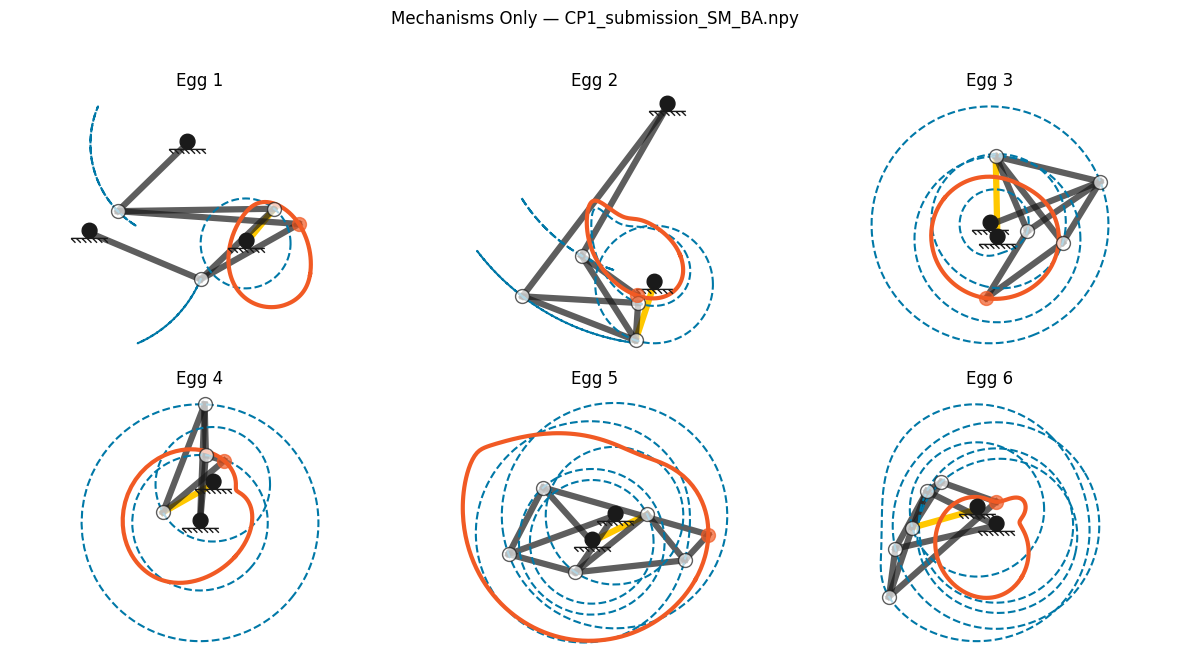

In [2]:
# === Mechanisms-Only Panel (starter-style drawing) ===
# Requires the same environment as the starter (LINKS/JAX available).

import os, glob, numpy as np, matplotlib.pyplot as plt

# ---------- locate files ----------
def find_submission():
    preferred = ["CP1_submission_SM_BA.npy", "my_full_submission.npy", "my_submission.npy", "submission.npy"]
    for name in preferred:
        if os.path.isfile(name):
            try:
                d = np.load(name, allow_pickle=True).item()
                if isinstance(d, dict) and all(f"Problem {i}" in d for i in range(1,7)):
                    return name
            except: pass
    for fn in glob.glob("*.npy"):
        try:
            d = np.load(fn, allow_pickle=True).item()
            if isinstance(d, dict) and all(f"Problem {i}" in d for i in range(1,7)):
                return fn
        except: pass
    raise FileNotFoundError("No submission .npy with keys 'Problem 1'..'Problem 6' found.")

def find_targets():
    for name in ["target_curves.npy", "targets.npy"]:
        if os.path.isfile(name): return name
    return None

SUB_PATH = find_submission()
TGT_PATH = find_targets()
submission = np.load(SUB_PATH, allow_pickle=True).item()
targets = np.load(TGT_PATH, allow_pickle=True) if TGT_PATH else None

# ---------- starter APIs ----------
from LINKS.Visualization import MechanismVisualizer
from LINKS.Optimization import Tools

visualizer = MechanismVisualizer()
TOOLS = Tools(device="cpu"); TOOLS.compile()

# ---------- helpers ----------
DIST_MAX, MAT_MAX = 0.75, 10.0

def as_int_array(x, length=None):
    if x is None: return np.asarray([], dtype=int)
    arr = np.asarray(x)
    if arr.dtype == bool:
        if length is None or arr.size != length: return np.asarray([], dtype=int)
        return np.where(arr)[0].astype(int)
    try:    return arr.astype(int)
    except: return np.asarray([], dtype=int)

def pick_best_by_distance(mech_list, target_curve):
    """Choose best-by-distance (feasible if possible); if no targets available, return index 0."""
    if targets is None or target_curve is None:
        return 0, None
    if not mech_list: return None, None
    x0s, edges, fixeds, motors, tjs = [], [], [], [], []
    for mech in mech_list:
        x0  = np.asarray(mech["x0"])
        ed  = np.asarray(mech["edges"], dtype=int)
        fx  = as_int_array(mech.get("fixed_joints", []), length=x0.shape[0])
        mot = np.asarray(mech["motor"], dtype=int)
        tj  = int(mech.get("target_joint", x0.shape[0]-1))
        x0s.append(x0); edges.append(ed); fixeds.append(fx); motors.append(mot); tjs.append(tj)
    F = np.array(TOOLS(x0s, edges, fixeds, motors, target_curve, tjs)).T  # (K,2) = [distance, material]
    feas = np.where((F[:,0] <= DIST_MAX) & (F[:,1] <= MAT_MAX))[0]
    idx = int(feas[np.argmin(F[feas,0])]) if len(feas)>0 else int(np.argmin(F[:,0]))
    return idx, F

# ---------- panel (mechanisms only) ----------
fig, axs = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle(f"Mechanisms Only — {os.path.basename(SUB_PATH)}", y=0.97, fontsize=12)

for i in range(6):
    ax = axs[i//3, i%3]
    mech_list = submission.get(f"Problem {i+1}", [])

    if not mech_list:
        ax.set_title(f"Egg {i+1}: no mechanisms"); ax.axis("off"); continue

    # pick which mechanism to draw
    if targets is not None:
        best_idx, _ = pick_best_by_distance(mech_list, targets[i])
        if best_idx is None: best_idx = 0
    else:
        best_idx = 0

    mech = mech_list[best_idx]
    x0   = np.asarray(mech["x0"])
    edges = np.asarray(mech["edges"], dtype=int)
    fixed = as_int_array(mech.get("fixed_joints", []), length=x0.shape[0])
    motor = np.asarray(mech["motor"], dtype=int)

    # draw exactly like the starter notebook does:
    visualizer(x0, edges, fixed, motor, ax=ax)  # solves & draws the mechanism
    ax.set_title(f"Egg {i+1}")
    ax.axis("equal"); ax.axis("off")

fig.tight_layout(rect=[0,0.03,1,0.95])
fig.savefig("mechanisms_only_panel.png", dpi=200, bbox_inches="tight")
fig.savefig("mechanisms_only_panel.pdf", bbox_inches="tight")
plt.show()


### Final submission sample mechanisms solutions vs target curves

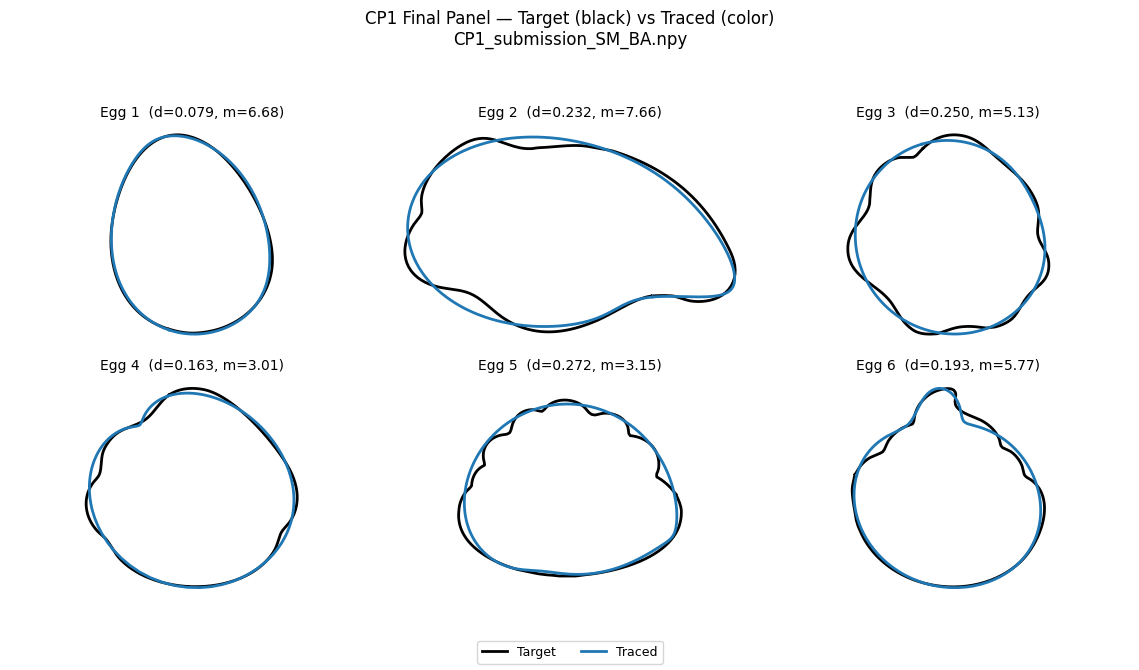

Egg | Distance | Material
  1 |   0.0790 |   6.6835
  2 |   0.2320 |   7.6572
  3 |   0.2505 |   5.1276
  4 |   0.1631 |   3.0068
  5 |   0.2716 |   3.1484
  6 |   0.1933 |   5.7704


In [4]:
# === CP1 Final Panel — Starter-Style Alignment (target black, traced aligned color) ===
# Requirements: same environment as starter (LINKS/JAX available).
# It finds your submission + targets automatically and makes a 2x3 panel.

import os, glob, numpy as np, matplotlib.pyplot as plt

# ---------- find files ----------
def find_submission():
    preferred = ["CP1_submission_SM_BA.npy", "my_full_submission.npy", "my_submission.npy", "submission.npy"]
    for name in preferred:
        if os.path.isfile(name):
            try:
                d = np.load(name, allow_pickle=True).item()
                if isinstance(d, dict) and all(f"Problem {i}" in d for i in range(1,7)):
                    return name
            except: pass
    for fn in glob.glob("*.npy"):
        try:
            d = np.load(fn, allow_pickle=True).item()
            if isinstance(d, dict) and all(f"Problem {i}" in d for i in range(1,7)):
                return fn
        except: pass
    raise FileNotFoundError("No submission .npy with keys 'Problem 1'..'Problem 6' found.")

def find_targets():
    for name in ["target_curves.npy", "targets.npy"]:
        if os.path.isfile(name): return name
    raise FileNotFoundError("target_curves.npy not found next to the notebook.")

SUB_PATH = find_submission()
TGT_PATH = find_targets()
submission = np.load(SUB_PATH, allow_pickle=True).item()
targets    = np.load(TGT_PATH, allow_pickle=True)

# ---------- import LINKS like the starter ----------
from LINKS.Kinematics import MechanismSolver
from LINKS.Optimization import Tools

solver = MechanismSolver(device="cpu")
TOOLS  = Tools(device="cpu"); TOOLS.compile()

# ---------- helpers ----------
DIST_MAX, MAT_MAX = 0.75, 10.0

def resample_polyline(xy, n=600):
    """Uniformly resample a polyline to n points by arc-length (starter-like density)."""
    xy = np.asarray(xy, dtype=float)
    seg = np.linalg.norm(np.diff(xy, axis=0), axis=1)
    s = np.concatenate([[0.0], np.cumsum(seg)])
    if s[-1] == 0:
        return np.repeat(xy[:1], n, axis=0)
    t = np.linspace(0, s[-1], n)
    x = np.interp(t, s, xy[:,0]); y = np.interp(t, s, xy[:,1])
    return np.column_stack([x, y])

def procrustes_align(X, Y):
    """Best-fit similarity (scale+rotate+translate) of X to Y via SVD; returns aligned X."""
    X = np.asarray(X, dtype=float); Y = np.asarray(Y, dtype=float)
    Xc = X - X.mean(axis=0); Yc = Y - Y.mean(axis=0)
    H = Xc.T @ Yc
    U, S, Vt = np.linalg.svd(H)
    R = U @ Vt
    if np.linalg.det(R) < 0:  # fix reflections
        U[:, -1] *= -1
        R = U @ Vt
    scale = (S.sum()) / (np.sum(Xc**2) + 1e-12)
    return scale * (Xc @ R) + Y.mean(axis=0)

def cyclic_align(trace_rs, target_rs, coarse_step=8, refine_halfwin=6):
    """
    Aligns closed curves by searching a cyclic shift (phase) AND a similarity transform.
    1) coarse search over n/coarse_step shifts,
    2) refine around the best.
    Returns (aligned_trace, best_shift).
    """
    n = len(trace_rs)
    assert n == len(target_rs)
    # coarse search
    candidates = list(range(0, n, max(1, n//(n//coarse_step if n//coarse_step else 1))))
    best_err, best_k, best_aligned = np.inf, 0, trace_rs
    for k in candidates:
        rolled = np.roll(trace_rs, k, axis=0)
        aligned = procrustes_align(rolled, target_rs)
        err = np.mean(np.sum((aligned - target_rs)**2, axis=1))
        if err < best_err:
            best_err, best_k, best_aligned = err, k, aligned
    # refine
    for dk in range(-refine_halfwin, refine_halfwin+1):
        k = (best_k + dk) % n
        rolled = np.roll(trace_rs, k, axis=0)
        aligned = procrustes_align(rolled, target_rs)
        err = np.mean(np.sum((aligned - target_rs)**2, axis=1))
        if err < best_err:
            best_err, best_k, best_aligned = err, k, aligned
    return best_aligned, best_k

def pick_best_by_distance(mech_list, target_curve):
    """Choose the best (feasible if possible) by distance using TOOLS (same constraints as starter)."""
    if not mech_list: return None, None, None
    x0s, edges, fixeds, motors, tjs = [], [], [], [], []
    for mech in mech_list:
        x0  = np.asarray(mech["x0"])
        ed  = np.asarray(mech["edges"], dtype=int)
        fx  = mech.get("fixed_joints", [])
        fx  = np.asarray(fx, dtype=int) if np.ndim(fx)>0 else (np.asarray([fx], dtype=int) if fx not in (None, []) else np.asarray([], dtype=int))
        mot = np.asarray(mech["motor"], dtype=int)
        tj  = mech.get("target_joint", x0.shape[0]-1)
        x0s.append(x0); edges.append(ed); fixeds.append(fx); motors.append(mot); tjs.append(int(tj))
    F = np.array(TOOLS(x0s, edges, fixeds, motors, target_curve, tjs)).T  # (K,2) [distance, material]
    feas = np.where((F[:,0] <= DIST_MAX) & (F[:,1] <= MAT_MAX))[0]
    idx = int(feas[np.argmin(F[feas,0])]) if len(feas)>0 else int(np.argmin(F[:,0]))
    return idx, F, (x0s, edges, fixeds, motors, tjs)

# ---------- plot with alignment ----------
fig, axs = plt.subplots(2, 3, figsize=(11.5, 6.7))
fig.suptitle(f"CP1 Final Panel — Target (black) vs Traced (color)\n{os.path.basename(SUB_PATH)}", y=0.98, fontsize=12)

metrics = []

for i in range(6):
    ax = axs[i//3, i%3]
    tgt = np.asarray(targets[i])
    tgt_rs = resample_polyline(tgt, n=600)
    ax.plot(tgt_rs[:,0], tgt_rs[:,1], color="black", linewidth=2, label="Target")

    mech_list = submission.get(f"Problem {i+1}", [])
    if not mech_list:
        ax.set_title(f"Egg {i+1}: no mechanisms"); ax.axis("equal"); ax.axis("off"); continue

    # choose and simulate
    best_idx, F, packs = pick_best_by_distance(mech_list, tgt)
    x0s, edges, fixeds, motors, tjs = packs
    sol = solver(x0s[best_idx], edges[best_idx], fixeds[best_idx], motors[best_idx])
    traced = sol[tjs[best_idx]]
    traced_rs = resample_polyline(traced, n=600)

    # cyclic + similarity alignment (starter-style feel)
    traced_aligned, _ = cyclic_align(traced_rs, tgt_rs)

    # draw
    ax.plot(traced_aligned[:,0], traced_aligned[:,1], linewidth=2, label="Traced")
    d_val = float(F[best_idx,0]); m_val = float(F[best_idx,1])
    metrics.append((i+1, d_val, m_val))
    ax.set_title(f"Egg {i+1}  (d={d_val:.3f}, m={m_val:.2f})", fontsize=10)

    ax.axis("equal"); ax.axis("off")

# legend + save
h, l = axs[0,0].get_legend_handles_labels()
if h: fig.legend(h, l, loc="lower center", ncol=2, fontsize=9)
fig.tight_layout(rect=[0,0.08,1,0.94])
fig.savefig("cp1_final_panel_aligned.png", dpi=200, bbox_inches="tight")
fig.savefig("cp1_final_panel_aligned.pdf", bbox_inches="tight")
plt.show()

# tiny table (copy-paste for report)
print("Egg | Distance | Material")
for egg, d, m in metrics:
    print(f"{egg:>3} | {d:8.4f} | {m:8.4f}")
